# Read data set

In [1]:
import os
import glob

def read_dir(dirname, extension):
    imgtypes = os.listdir(dirname)
    results = []
    for imtype in imgtypes:
        npath= dirname + imtype + '/*.' + extension
        results.extend(glob.glob(npath))
    return results

def read_dataset():
    v_images = read_dir('vehicles/', 'png')
    nv_images = read_dir('non-vehicles/', 'png')
    return (v_images, nv_images)

In [2]:
from skimage.feature import hog
import numpy as np
import cv2

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec):
    
    transform_sqrt=False # this does not work for -ve values in img
    block_norm='L2-Hys'
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm=block_norm,
                                  transform_sqrt=transform_sqrt, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block), block_norm=block_norm,
                      transform_sqrt=transform_sqrt, visualise=vis, feature_vector=feature_vec)
        
        if (np.isnan(np.min(features))):
            from IPython.core.debugger import Tracer; Tracer()() 
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(image, color_space):
    if color_space == 'RGB':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: 
        feature_image = np.copy(image)   
    return feature_image
        
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space, spatial_size,
                    hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                    spatial_feat, hist_feat, hog_feat):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = image.astype(np.float32)
        feature_image = convert_color(image, color_space)  

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            color_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(color_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
            
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, vis,
                        spatial_feat, hist_feat, hog_feat):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space) 
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=vis, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    if vis == True:
        #9) Return concatenated array of features
        return np.concatenate(img_features), hog_image
    else:
        #9) Return concatenated array of features
        return np.concatenate(img_features)
   
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size, hist_bins, 
                    orient, pix_per_cell, cell_per_block, hog_channel, 
                    spatial_feat, hist_feat, hog_feat):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, vis=False,
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = np.array(features).reshape(1, -1)
        test_features = scaler.transform(test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    #8) Return windows for positive detections
    return on_windows


def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])

In [3]:
%matplotlib inline
from random import randint
import matplotlib.pyplot as plt

def sample_feature_visualization(car_images, not_car_images, num_samples):
    for i in range(0, num_samples):
        car_image = cv2.imread(car_images[randint(0, len(car_images))])
        car_image = np.array(car_image).astype(np.float32)
        not_car_image = cv2.imread(not_car_images[randint(0, len(not_car_images))])
        not_car_image = np.array(not_car_image).astype(np.float32)
        
        print ("Pixel Range: Min - {}. Max - {}".format(np.min(car_image), np.max(car_image)))
        color_space = 'YCrCb'
        orient = 9
        pix_per_cell=8
        cell_per_block=2
        hog_channel=0
        spatial_size = (32,32)
        hist_bins=32
        spatial_feat=True
        hist_feat=True
        hog_feat=True

        car_features, car_hog_image = single_img_features(car_image, 
                                         color_space=color_space,
                                         spatial_size=spatial_size, 
                                         hist_bins=hist_bins,
                                         orient=orient,
                                         pix_per_cell=8,
                                         cell_per_block=2,
                                         hog_channel=hog_channel,
                                         vis=True,
                                         spatial_feat=spatial_feat,
                                         hist_feat=hist_feat,
                                         hog_feat=hog_feat)
        not_car_features, not_car_hog_image = single_img_features(not_car_image, 
                                         color_space=color_space,
                                         spatial_size=spatial_size, 
                                         hist_bins=hist_bins,
                                         orient=orient,
                                         pix_per_cell=8,
                                         cell_per_block=2,
                                         hog_channel=hog_channel,
                                         vis=True,
                                         spatial_feat=spatial_feat,
                                         hist_feat=hist_feat,
                                         hog_feat=hog_feat)

        images = [car_image, car_hog_image, not_car_image, not_car_hog_image]
        titles = ['Car', 'Car HOG', 'Not Car', 'Not Car HOG']
        fig = plt.figure(figsize=(12,3))
        visualize(fig, 1, 4, images, titles)

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from random import sample
import time

color_space = 'YCrCb'
orient = 9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_size = (32,32)
hist_bins=32
spatial_feat=True
hist_feat=True
hog_feat=True


def train(car_images, not_car_images):

    sample_size = 30
    random_idxs = sample(range(0, len(car_images)), sample_size)
    
    test_cars = np.array(car_images)[random_idxs]
    test_notcars = np.array(not_car_images)[random_idxs]

    car_features = extract_features(test_cars, 
                                 color_space=color_space,
                                 spatial_size=spatial_size, 
                                 hist_bins=hist_bins,
                                 orient=orient,
                                 pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel,
                                 spatial_feat=spatial_feat,
                                 hist_feat=hist_feat,
                                 hog_feat=hog_feat)
    not_car_features = extract_features(test_notcars, 
                                     color_space=color_space,
                                     spatial_size=spatial_size, 
                                     hist_bins=hist_bins,
                                     orient=orient,
                                     pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,
                                     hog_channel=hog_channel,
                                     spatial_feat=spatial_feat,
                                     hist_feat=hist_feat,
                                     hog_feat=hog_feat)
    
    X = np.vstack((car_features, not_car_features)).astype(np.float64)       
    
    print ("Training feature shape: {}".format(X.shape))
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.1, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    parameters = {'kernel':('poly', 'rbf'), 'C': [1, 10, 100]}
    svr = SVC()
    clf = GridSearchCV(svr, parameters)
    # Check the training time for the SVC
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print ("Best Parameters: {}".format(clf.best_params_))
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    return (clf, X_scaler) # return the best classifier

Number of vehicle images: 8792
Number of non-vehicle images: 8968
Pixel Range: Min - 3.0. Max - 255.0
Training feature shape: (60, 8460)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
0.93 Seconds to train SVC...
Best Parameters: {'kernel': 'rbf', 'C': 1}
Test Accuracy of SVC =  0.8333


['scaler.pk']

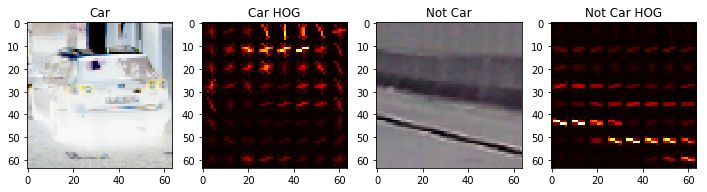

In [5]:
from sklearn.externals import joblib

(v_images, nv_images) = read_dataset()
print ("Number of vehicle images: {}".format(len(v_images)))
print ("Number of non-vehicle images: {}".format(len(nv_images)))

sample_feature_visualization(v_images, nv_images, 1)
clf, scaler = train(v_images, nv_images)

scaler_file = 'scaler.pk'
model_file = 'model.pk'
joblib.dump(clf, model_file)
joblib.dump(scaler, scaler_file)

# Test Classifier on test images - Slow

Number of test images: 6
1.7119438648223877 seconds to process one image. Windows: 100
1.7162508964538574 seconds to process one image. Windows: 100
1.910658836364746 seconds to process one image. Windows: 100
1.7340724468231201 seconds to process one image. Windows: 100
1.7255127429962158 seconds to process one image. Windows: 100
1.7034568786621094 seconds to process one image. Windows: 100


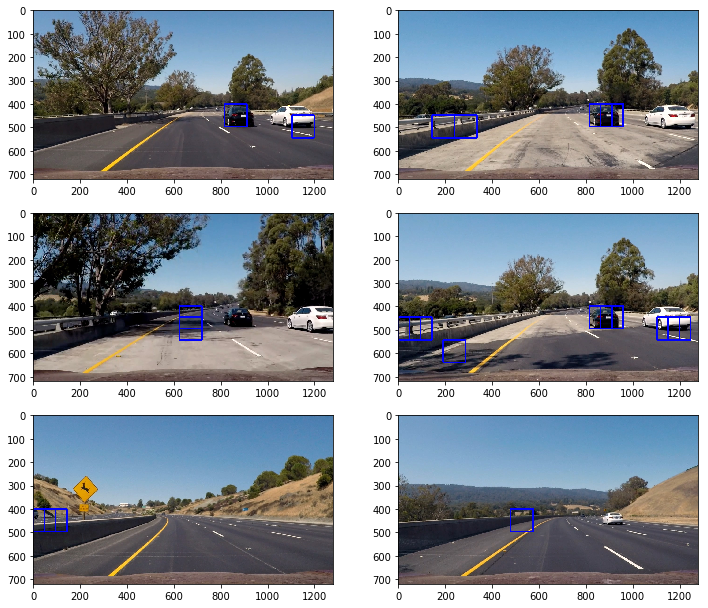

In [6]:
%matplotlib inline

test_img_path = 'test_images/'
test_images = glob.glob(test_img_path + '*.jpg')
print ("Number of test images: {}".format(len(test_images)))

clf = joblib.load(model_file)
scaler = joblib.load(scaler_file)

images=[]
titles = []
y_start_stop=[400,680]
overlap=0.5
xy_window=(96,96)

for img_file in test_images:
    t1 = time.time()
    img = cv2.imread(img_file)
    draw_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    
    windows = slide_window(img, x_start_stop=[None,None], y_start_stop=y_start_stop,
                          xy_window=xy_window, xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, clf, scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print ("{} seconds to process one image. Windows: {}".format(time.time()-t1, len(windows)))

fig = plt.figure(figsize=(12,18))
visualize(fig, 5, 2, images, titles)

In [11]:
def find_cars(img, draw_img, ystart, yend, scale, clf, scaler):
    t = time.time()
    img = img.astype(np.float32)
    
    search_img=img[ystart:yend,:,:]
    ctrans_search=convert_color(search_img,color_space)

    if scale != 1:
        imshape = ctrans_search.shape
        # resize the image instead of resizing the boxes. The effect is the same
        ctrans_search = cv2.resize(ctrans_search, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # get the hog features of the scaled image
    ch1 = ctrans_search[:,:,0]
    ch2 = ctrans_search[:,:,1]
    ch3 = ctrans_search[:,:,2]
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    # Define blocks and steps
    width = ch1.shape[1]
    height = ch1.shape[0]
    nxcells = width // pix_per_cell
    nycells = height // pix_per_cell

    # original window size
    window = 64
    window_cells = window // pix_per_cell

    # blocks are like 1 d conv moving 1 cell at a time
    nxblocks = nxcells - cell_per_block + 1 
    nyblocks = nycells - cell_per_block + 1
    nblocks_per_window = window_cells - cell_per_block + 1 

    cells_per_step=2 # 75% overlap
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    #print ("nxblocks: {}, nyblocks: {}".format(nxblocks, nyblocks))
    #print ("window blocks: {}".format(nblocks_per_window))
    #print ("nxsteps: {}, nysteps: {}".format(nxsteps, nysteps))
    
    heatmap = np.zeros_like(img[:,:,0])
    count=0 # number of boxes
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1

            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            # extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_search[ytop:ytop+window, xleft:xleft+window], (window,window))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # careful of the order!
            features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
            # scale features and make the prediction
            scaled_features = scaler.transform(features)
            prediction = clf.predict(scaled_features)

            if prediction == 1:
                win_draw = np.int(window*scale)
                xbox_left = np.int(xleft*scale)
                xbox_right = xbox_left + win_draw
                ytop_draw = ystart + np.int(ytop*scale)
                ybot_draw = ytop_draw + win_draw

                cv2.rectangle(draw_img, 
                              (xbox_left, ytop_draw), 
                              (xbox_right, ybot_draw),
                              (0,0,255), 6)
                heatmap[ytop_draw:ybot_draw, xbox_left:xbox_right] += 1
    
    print("{} seconds to run for {} windows".format(time.time() - t, count))
    return heatmap


def apply_heat_threshold(heatmap, threshold):
    heatmap[heatmap < threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] + 1):
        # find pixels for the car_number
        nonzero = (labels[0] == car_number).nonzero()
        
        # identify x and y
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # draw a bounding box based on mix/max values
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # draw the rectangle
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        
    return img

In [8]:
def process_video_frame(img):
    heatmap = np.zeros_like(img[:,:,0])
    out_img = np.copy(img)
    heatmap = find_cars(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), out_img, 
                        ystart=400, yend=680, scale=2, clf=clf, scaler=scaler)
    
    heat_map = apply_heat_threshold(heat_map, threshold=3)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

4.201139211654663 seconds to run for 988 windows
0.7127275466918945 seconds to run for 144 windows
4.425994157791138 seconds to run for 988 windows
0.7555553913116455 seconds to run for 144 windows
4.471817970275879 seconds to run for 988 windows
0.7232394218444824 seconds to run for 144 windows
4.070973634719849 seconds to run for 988 windows
0.7162094116210938 seconds to run for 144 windows
4.095822095870972 seconds to run for 988 windows
0.7158412933349609 seconds to run for 144 windows
4.019390344619751 seconds to run for 988 windows
0.7335536479949951 seconds to run for 144 windows


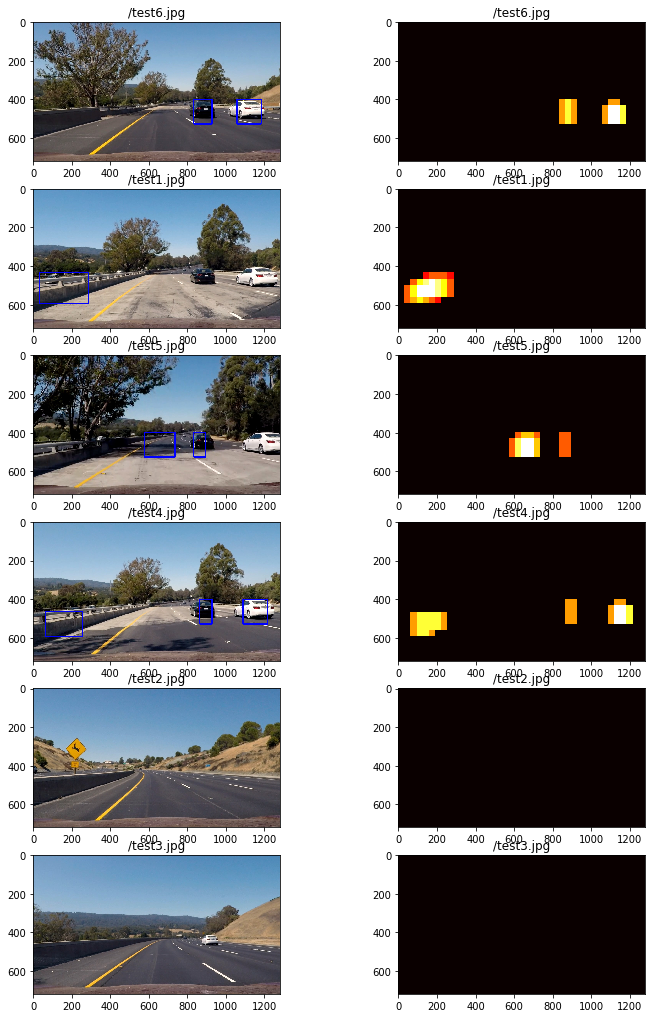

In [12]:
from scipy.ndimage.measurements import label

out_images= []
out_titles = []
for img_file in test_images:
    img=cv2.imread(img_file)
    
    draw_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    overall_heatmap = np.zeros_like(img[:,:,0])
    for scale in [1.0, 2.0]:
        heatmap = find_cars(img, draw_img, ystart=400, yend=680, scale=scale, clf=clf, scaler=scaler)
        overall_heatmap = np.add(overall_heatmap, heatmap)
        
    overall_heatmap = apply_heat_threshold(heatmap, threshold=3)
    
    labels = label(overall_heatmap)
    draw_img = draw_labeled_bboxes(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels)
    
    out_images.append(draw_img)
    out_images.append(overall_heatmap)
    out_titles.append(img_file[-10:])
    out_titles.append(img_file[-10:])
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'

clip = VideoFileClip("test_video.mp4")
#test_clip = clip.fl_image(process_video_frame)
#test_clip.write_videofile(test_output, audio=False)